In [3]:
#imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [4]:
df_encoded= pd.read_csv('encoded_abortion_data.csv')
df_encoded.head()

,Patient_ID,Gestation_at_Abortion_Weeks,Age_of_Mother,Year,Relationship_Status_Cohabitating,Relationship_Status_Divorced,Relationship_Status_Married,Relationship_Status_Single,Relationship_Status_Widowed,Race_Asian,...,Medical_Complications_to_Child_Birth asphyxia,Medical_Complications_to_Child_Cleft lip or palate,Medical_Complications_to_Child_Congenital heart defects,Medical_Complications_to_Child_Down syndrome,Medical_Complications_to_Child_Intrauterine growth restriction (IUGR),Medical_Complications_to_Child_Jaundice,Medical_Complications_to_Child_No,Medical_Complications_to_Child_Other,Medical_Complications_to_Child_Premature birth,Medical_Complications_to_Child_Still Born
0,1,11.5,22,2021,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
1,2,9.6,23,2024,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
2,3,8.4,14,2015,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,4,9.6,18,2021,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,5,8.7,45,2018,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [5]:
#DiD model
complication_cols = [
    'Medical_Complications_to_Mother_Anesthesia Reaction',
    'Medical_Complications_to_Mother_Hemorrhage',
    'Medical_Complications_to_Mother_Infection',
    'Medical_Complications_to_Mother_Uterine Perforation'
]

df_encoded['Treatment'] = df_encoded['Legal_Status_of_Abortion_Banned']  
df_encoded['Post'] = (df_encoded['Year'] >= 2022).astype(int)             
df_encoded['DiD'] = df_encoded['Treatment'] * df_encoded['Post']     
#outcome var
df_encoded['Complication'] = (df_encoded[complication_cols].sum(axis=1) > 0).astype(int)


features = ['Treatment', 'Post', 'DiD', 'Age_of_Mother', 'Gestation_at_Abortion_Weeks', 'Race_Asian', 'Race_Hispanic', 'Race_Multiracial', 'Race_Native American', 'Race_Non-Hispanic Black', 'Race_Non-Hispanic White', 'Race_Pacific Islander', 
            'Economic_Status_High Income', 'Economic_Status_Low Income', 'Economic_Status_Middle Income', 'Economic_Status_On government assistance', 
            'Economic_Status_Underemployed', 'Economic_Status_Unemployed', 'Insurance_Military Insurance', 'Insurance_Other', 'Insurance_Private Insurance', 'Insurance_Public/Federal Insurance', 
            'Insurance_Short-term Insurance', 'Insurance_Uninsured', 'Travel_Out_of_State_True']

In [6]:
X = df_encoded[features]
y = df_encoded['Complication']
#scaling for stability
scaler = StandardScaler()
scaled = scaler.fit_transform(df_encoded[['Age_of_Mother', 'Gestation_at_Abortion_Weeks']])
# Create X by selecting all the features
X = df_encoded[features].copy()
# Add the scaled columns to X
X[['Age_of_Mother', 'Gestation_at_Abortion_Weeks']] = scaled

clf = LogisticRegression(class_weight='balanced', max_iter=5000)
clf.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [7]:
y_prob = clf.predict_proba(X)[:, 1]
y_pred_thresh = (y_prob >= 0.3).astype(int)
print(classification_report(y, y_pred_thresh))
#y_pred = clf.predict(X)
#print(classification_report(y, y_pred))

# Coefficients
for feat, coef in zip(X.columns, clf.coef_[0]):
    print(f"{feat}: Coef = {coef:.4f}, Odds Ratio = {np.exp(coef):.4f}")

              precision    recall  f1-score   support

           0       0.98      0.02      0.05     18240
           1       0.09      0.99      0.16      1760

    accuracy                           0.11     20000
   macro avg       0.53      0.51      0.11     20000
weighted avg       0.90      0.11      0.06     20000

Treatment: Coef = 0.0568, Odds Ratio = 1.0585
Post: Coef = -0.0419, Odds Ratio = 0.9590
DiD: Coef = 0.1172, Odds Ratio = 1.1243
Age_of_Mother: Coef = -0.0470, Odds Ratio = 0.9541
Gestation_at_Abortion_Weeks: Coef = 0.3976, Odds Ratio = 1.4882
Race_Asian: Coef = 0.0966, Odds Ratio = 1.1014
Race_Hispanic: Coef = -0.0725, Odds Ratio = 0.9301
Race_Multiracial: Coef = -0.0488, Odds Ratio = 0.9523
Race_Native American: Coef = 0.0003, Odds Ratio = 1.0003
Race_Non-Hispanic Black: Coef = 0.0410, Odds Ratio = 1.0418
Race_Non-Hispanic White: Coef = -0.0155, Odds Ratio = 0.9846
Race_Pacific Islander: Coef = -0.0300, Odds Ratio = 0.9705
Economic_Status_High Income: Coef = 0.035

In [ ]:
coefficients = clf.coef_[0]
features = X.columns
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Plot Coefficients with Confidence Intervals
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='lightpink')
plt.xlabel('Coefficient Value')
plt.title('Model Coefficients for Logistic Regression')
plt.show()

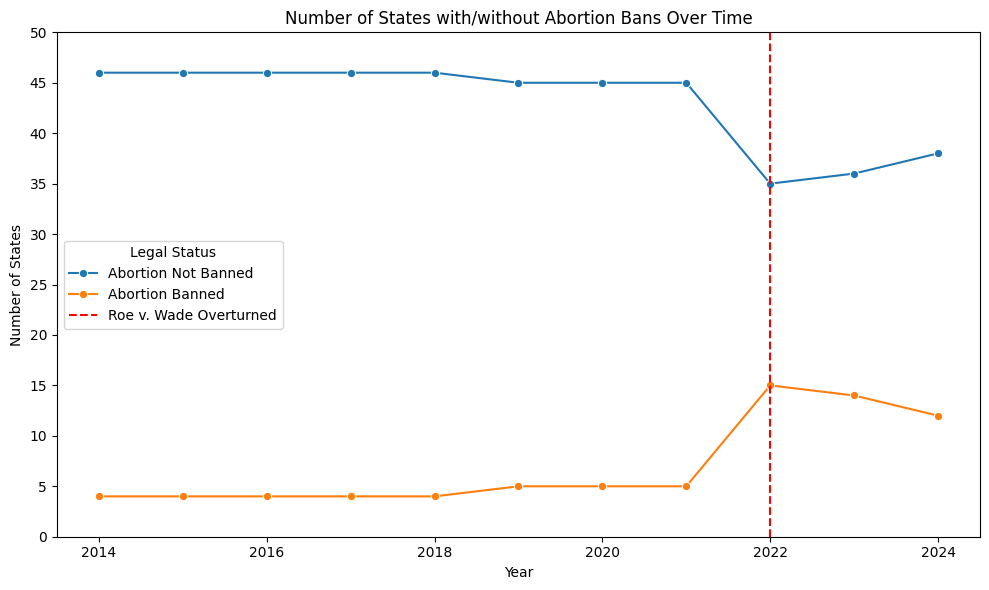

In [22]:
state_counts = (
    df_encoded.groupby(['Year', 'Treatment'])['State'].nunique().reset_index(name='Num_States')
)
state_counts['Treatment_Label'] = state_counts['Treatment'].map({
    True: 'Abortion Banned',
    False: 'Abortion Not Banned'
})

# Plot with clearer labels
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Year',
    y='Num_States',
    hue='Treatment_Label',
    data=state_counts,
    marker='o'
)
plt.axvline(x=2022, linestyle='--', color='red', label='Roe v. Wade Overturned')
plt.title('Number of States with/without Abortion Bans Over Time')
plt.xlabel('Year')
plt.ylabel('Number of States')
plt.yticks(range(0, state_counts['Num_States'].max() + 5, 5))
plt.legend(title='Legal Status')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the average complication rate for each group by year
complication_trends = df_encoded.groupby(['Year', 'Treatment'])['Complication'].mean().reset_index()
complication_trends['Treatment_Label'] = complication_trends['Treatment'].map({
    True: 'Abortion Banned',
    False: 'Abortion Not Banned'
})
# Plot the trends
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Year',
    y='Complication',
    hue='Treatment_Label',
    data=complication_trends,
    marker='o'
)
plt.axvline(x=2022, linestyle='--', color='red', label='Roe v. Wade Overturned')
plt.title('Average Complication Rate Over Time by Abortion Ban Status')
plt.xlabel('Year')
plt.ylabel('Average Complication Rate')
plt.legend(title='Legal Status')
plt.tight_layout()
plt.show()

In [ ]:
# Group by year and compute average complication rate
bins = [0, 19, 24, 29, 34, 39, 49, 100]
labels = ['≤19', '20–24', '25–29', '30–34', '35–39', '40–49', '50+']
df_encoded['Age_Group'] = pd.cut(df_encoded['Age_of_Mother'], bins=bins, labels=labels, right=True)
complication_by_age = df_encoded.groupby(['Year', 'Age_Group'], observed=False)['Complication'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.lineplot(data=complication_by_age, x='Year', y='Complication', hue='Age_Group', marker='o')
plt.axvline(x=2022, linestyle='--', color='red', label='Roe v. Wade Overturned')
plt.title('Average Complication Rate Per Year by Age Group', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Average Complication Rate', fontsize=13)
plt.legend(title='Age Group')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(data=complication_by_age, x='Year', y='Complication', hue='Age_Group')

plt.axvline(x=complication_by_age['Year'].unique().tolist().index(2022) - 0.5,
            linestyle='--', color='red', label='Roe v. Wade Overturned')

plt.title('Average Complication Rate Per Year by Age Group', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Complication Rate', fontsize=14)
plt.legend(title='Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

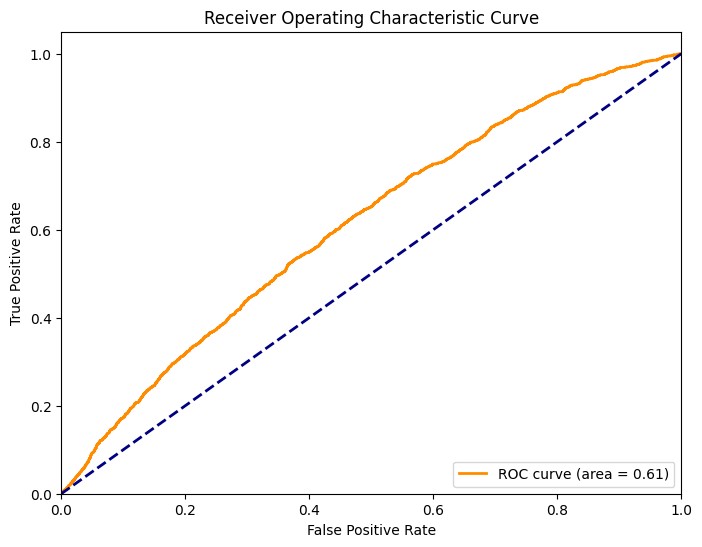

In [10]:
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
state_columns = [col for col in df_encoded.columns if col.startswith('State_')]

df_encoded['State'] = df_encoded[state_columns].idxmax(axis=1).str.replace('State_', '')
state_complications = df_encoded.groupby(['State', 'Post'])['Complication'].mean().reset_index()
state_order = sorted(df_encoded['State'].unique())

# Plotting
plt.figure(figsize=(20, 8))
palette = {0: 'steelblue', 1: 'darkorange'}
sns.lineplot(x='State', y='Complication', hue='Post', data=state_complications, marker='o')
for x in range(len(state_order)):
    plt.axvline(x=x, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

plt.title('Complication Rate Trend by State: Pre and Post 2022', fontsize=18)
plt.xlabel('State', fontsize=16)
plt.ylabel('Average Complication Rate', fontsize=16)
plt.xticks(ticks=range(len(state_order)), labels=state_order, rotation=90, fontsize=14)
plt.yticks(fontsize=12)
#plt.legend(title='Post-2022 Status', labels=['Pre-2022', 'Post-2022'], title_fontsize=13, fontsize=12)

legend_handles = [
    Patch(color='steelblue', label='Pre 2022'),
    Patch(color='darkorange', label='Post 2022')
]
plt.legend(handles=legend_handles, title='Period')

plt.tight_layout()
plt.show()